In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Plotting helper functions

In [889]:
def plot_miscoverage_examples(test_dataset, coverages, intervals):
    miscovered_idx = torch.nonzero(~coverages, as_tuple=False)[:, 0].tolist()
    fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

    for ax in axs.flat:
        i = np.random.choice(miscovered_idx)
        ax.fill_between(range(test_dataset[i][1].size(0)),
                         intervals[i, 0].flatten().tolist(), 
                         intervals[i, 1].flatten().tolist(), 
                         color="r", alpha=0.25)
        ax.plot(intervals[i, 0].flatten().tolist(), linestyle="--", color="r")
        ax.plot(intervals[i, 1].flatten().tolist(), linestyle="--", color="r")
        ax.plot((intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist(), linestyle="--", linewidth=3, color="r")

        ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].flatten().tolist(), color="black")

        ax.set(xlabel='Time step', ylabel='Prediction')
    plt.show()
    
def plot_ts(dataset, coverages, intervals, idx=None, forecast_only=False):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 8), sharex=True)
    
    if idx is None:
        idx = range(len(dataset))

    for ax in axs.flat:
        i = np.random.choice(idx)
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        
        horizon = min(len(target), length)
        sequence, target = sequence[:length].flatten().tolist(), target[:horizon].flatten().tolist()
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + intervals[i, 0].flatten().tolist()[:horizon]
        upper = [sequence[-1]] + intervals[i, 1].flatten().tolist()[:horizon]
        pred = [sequence[-1]] + (intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist()[:horizon]
        
        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

        ax.set(ylabel='Prediction')
    
    plt.xlabel('Time step')
    #     plt.ylabel('Prediction')
    plt.show()

## Hyperparameters

In [963]:
# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = [0.1 * k for k in range(seq_len + horizon)]
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

## Generate datasets

In [964]:
from utils.make_data import generate_autoregressive_forecast_dataset
train_dataset = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)

## Conformal forecaster

In [965]:
from models.conformal import ConformalForecaster
model = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)

In [966]:
model.fit(train_dataset, calibration_dataset, epochs=epochs, lr=lr, batch_size=batch_size)

Epoch: 0	Train loss: 90.03600997924805
Epoch: 50	Train loss: 16.06012830734253
Epoch: 100	Train loss: 13.419668865203857
Epoch: 150	Train loss: 12.036290264129638
Epoch: 200	Train loss: 10.706856536865235
Epoch: 250	Train loss: 9.539083862304688
Epoch: 300	Train loss: 8.627713441848755
Epoch: 350	Train loss: 8.575873565673827
Epoch: 400	Train loss: 8.18711452484131
Epoch: 450	Train loss: 7.170155477523804
Epoch: 500	Train loss: 7.597601652145386
Epoch: 550	Train loss: 8.1293475151062
Epoch: 600	Train loss: 6.668988990783691
Epoch: 650	Train loss: 6.817715740203857
Epoch: 700	Train loss: 6.375599479675293
Epoch: 750	Train loss: 6.400059652328491
Epoch: 800	Train loss: 6.817319059371949
Epoch: 850	Train loss: 7.949629306793213
Epoch: 900	Train loss: 6.128638410568238
Epoch: 950	Train loss: 6.272935771942139


## Coverage evaluation

In [967]:
coverages, intervals = model.evaluate_coverage(test_dataset)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages.float(), dim=0).item()))

% of series within predicted intervals: 0.9200000166893005


## Plotting

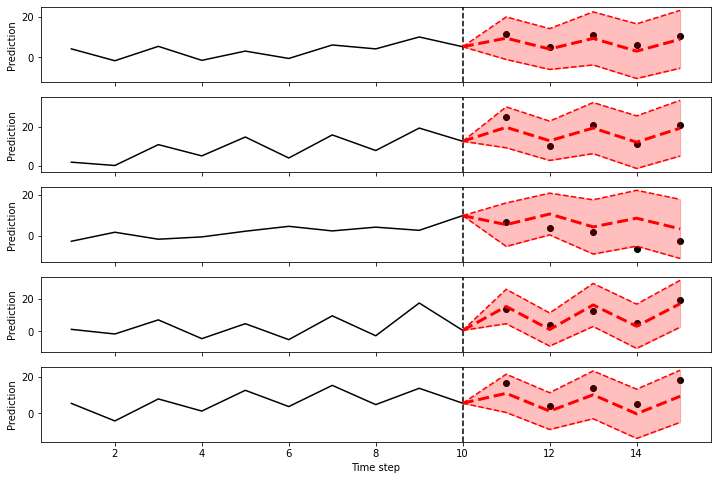

In [968]:
plot_ts(test_dataset, coverages, intervals)

Interval widths:

In [977]:
(intervals[:, 1] - intervals[:, 0]).squeeze().mean(dim=0).tolist()

[21.165647506713867,
 20.323575973510742,
 26.415739059448242,
 27.204988479614258,
 28.79669761657715]

In [976]:
(intervals[:, 1] - intervals[:, 0]).squeeze().mean()

tensor(24.7813, grad_fn=<MeanBackward0>)

In comparison with BJ-RNN on the same dataset and parameters (with the underlying RNN achieving the same training loss), Conformal forecaster:
* was significantly, incomparatively faster
* while it has lower empirical coverage (92% vs 100%) it is still at the sufficient level satisfying the theoretical guarantees
* has much smaller interval widths (24.7813 vs 231.94795306396472)


## Collecting all data

Things to try:
1. increasing (time-dependent) noise variance, no periodicity: try visibly increasing series
2. noise sweep (*will probably require normalisation* for good performance but should still show guarantees although with wide intervals for the wide examples)
3. periodic patterns
4. different time series lengths

In [978]:
from utils.train_conformal import train_conformal_forecaster

In [ ]:
results = []
for i in range(1, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    result = train_conformal_forecaster(noise_profile=noise_profile)
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results.append(result)

In [983]:
from utils.make_data import generate_autoregressive_forecast_dataset

train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)

## Conformal forecaster

In [984]:
from models.conformal import ConformalForecaster
model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)

In [985]:
model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)

Epoch: 0	Train loss: 96.71368026733398
Epoch: 50	Train loss: 16.560448932647706
Epoch: 100	Train loss: 14.431479930877686
Epoch: 150	Train loss: 12.659294700622558
Epoch: 200	Train loss: 12.42998971939087
Epoch: 250	Train loss: 10.524146461486817
Epoch: 300	Train loss: 9.547363376617431
Epoch: 350	Train loss: 9.923514461517334
Epoch: 400	Train loss: 9.386300659179687
Epoch: 450	Train loss: 9.263593387603759
Epoch: 500	Train loss: 8.214104843139648
Epoch: 550	Train loss: 7.847737741470337
Epoch: 600	Train loss: 7.737237644195557
Epoch: 650	Train loss: 7.695864248275757
Epoch: 700	Train loss: 7.722361993789673
Epoch: 750	Train loss: 7.293479585647583
Epoch: 800	Train loss: 7.3325395584106445
Epoch: 850	Train loss: 6.865914535522461
Epoch: 900	Train loss: 6.8702412128448485
Epoch: 950	Train loss: 9.24401330947876


In [986]:
# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results = []
for i in range(1, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results.append(result)
    

Epoch: 0	Train loss: 93.6583969116211
Epoch: 50	Train loss: 16.307931995391847
Epoch: 100	Train loss: 14.921547126770019
Epoch: 150	Train loss: 13.85702428817749
Epoch: 200	Train loss: 12.792230319976806
Epoch: 250	Train loss: 11.747208213806152
Epoch: 300	Train loss: 10.877283763885497
Epoch: 350	Train loss: 10.84754819869995
Epoch: 400	Train loss: 9.792602157592773
Epoch: 450	Train loss: 9.538048362731933
Epoch: 500	Train loss: 9.103987741470338
Epoch: 550	Train loss: 8.536530685424804
Epoch: 600	Train loss: 8.183154964447022
Epoch: 650	Train loss: 7.824663877487183
Epoch: 700	Train loss: 8.21445279121399
Epoch: 750	Train loss: 7.824004602432251
Epoch: 800	Train loss: 7.423264789581299
Epoch: 850	Train loss: 9.015694332122802
Epoch: 900	Train loss: 7.0830858707427975
Epoch: 950	Train loss: 7.266385555267334
Model 1:	coverage: 0.9259999990463257	widths: [19.406827926635742, 18.344846725463867, 25.127168655395508, 23.551210403442383, 30.696773529052734]
Epoch: 0	Train loss: 97.99895095

In [991]:
# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=4000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

# results_4000 = []
for i in range(5, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_4000.append(result)
    

Epoch: 0	Train loss: 131.66316909790038
Epoch: 50	Train loss: 57.15425033569336
Epoch: 100	Train loss: 53.97360000610352
Epoch: 150	Train loss: 50.63601493835449
Epoch: 200	Train loss: 46.72647476196289
Epoch: 250	Train loss: 43.096554565429685
Epoch: 300	Train loss: 39.958683013916016
Epoch: 350	Train loss: 39.79352645874023
Epoch: 400	Train loss: 36.788832092285155
Epoch: 450	Train loss: 36.722150039672854
Epoch: 500	Train loss: 35.21601257324219
Epoch: 550	Train loss: 35.63125381469727
Epoch: 600	Train loss: 34.07886371612549
Epoch: 650	Train loss: 32.697760009765624
Epoch: 700	Train loss: 32.290945816040036
Epoch: 750	Train loss: 35.08457450866699
Epoch: 800	Train loss: 34.27659873962402
Epoch: 850	Train loss: 30.97606506347656
Epoch: 900	Train loss: 30.8461051940918
Epoch: 950	Train loss: 32.64703636169433
Epoch: 1000	Train loss: 31.458338737487793
Epoch: 1050	Train loss: 34.405197334289554
Epoch: 1100	Train loss: 29.644252967834472
Epoch: 1150	Train loss: 29.563762664794922
Epoch

In [994]:
for result in results_4000:
    print(result['mean_coverage'])

0.9160000085830688
0.9340000152587891
0.9359999895095825
0.9139999747276306
0.9319999814033508


In [995]:
import pickle

In [996]:
with open('results_4000_epochs_increasing_time_dependent_noise.pkl', 'wb') as output:
    pickle.dump(results_4000, output, pickle.HIGHEST_PROTOCOL)

In [997]:
len(results)

5

In [998]:
with open('results_1000_epochs_increasing_time_dependent_noise.pkl', 'wb') as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [999]:
for result in results:
    print(result['mean_coverage'])

0.9259999990463257
0.9200000166893005
0.9319999814033508
0.8740000128746033
0.8600000143051147


## Static noise, no periodic component

In [1012]:
from models.conformal import ConformalForecaster
from utils.make_data import generate_autoregressive_forecast_dataset, seasonal

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = None
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results_static_noise_no_periodic = []
for i in range(1, 6):
    noise_profile = [0.1 * i for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_static_noise_no_periodic.append(result)

Epoch: 0	Train loss: 67.0411334991455
Epoch: 50	Train loss: 9.493545627593994
Epoch: 100	Train loss: 7.949249505996704
Epoch: 150	Train loss: 6.495412063598633
Epoch: 200	Train loss: 5.038233852386474
Epoch: 250	Train loss: 4.586574816703797
Epoch: 300	Train loss: 3.938397264480591
Epoch: 350	Train loss: 4.152902340888977
Epoch: 400	Train loss: 3.4305545330047607
Epoch: 450	Train loss: 3.4036927700042723
Epoch: 500	Train loss: 3.1382314920425416
Epoch: 550	Train loss: 3.7801637649536133
Epoch: 600	Train loss: 3.7448605060577393
Epoch: 650	Train loss: 3.283921718597412
Epoch: 700	Train loss: 3.07552285194397
Epoch: 750	Train loss: 2.7147955656051637
Epoch: 800	Train loss: 3.470752310752869
Epoch: 850	Train loss: 2.704321789741516
Epoch: 900	Train loss: 2.6370020389556883
Epoch: 950	Train loss: 5.021201276779175
Model 1:	coverage: 0.9340000152587891	widths: [11.87833023071289, 16.612380981445312, 19.602855682373047, 22.665311813354492, 24.152437210083008]
Epoch: 0	Train loss: 65.21984100

In [1013]:
with open('results_1000_epochs_results_static_noise_no_periodic.pkl', 'wb') as output:
    pickle.dump(results_static_noise_no_periodic, output, pickle.HIGHEST_PROTOCOL)

In [1023]:
with open('results_1000_epochs_results_static_noise_no_periodic.pkl', 'rb') as f:
    results_static_noise_no_periodic = pickle.load(f)

## Time-dependent noise, no periodic component

In [ ]:
from utils.make_data import generate_autoregressive_forecast_dataset
from utils.train_conformal import train_conformal_forecaster

results_time_dependent_noise_no_periodic = []
for i in range(1, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    result = train_conformal_forecaster(noise_profile=noise_profile)
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_time_dependent_noise_no_periodic.append(result)

In [1034]:
from models.conformal import ConformalForecaster
from utils.make_data import generate_autoregressive_forecast_dataset, seasonal

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = None
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results_time_dependent_noise_no_periodic = []
models = []
test_datasets = []
for i in range(1, 6):
    noise_profile = [0.1 * i * k for k in range(seq_len + horizon)]
    train_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
    calibration_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    test_dataset_x = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                                   seq_len=seq_len, 
                                                                   horizon=horizon, 
                                                                   periodicity=periodicity,
                                                                   noise_profile=noise_profile, 
                                                                   amplitude=amplitude,
                                                                   dynamic_sequence_lengths=dynamic_sequence_lengths)
    model_x = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)
    
    model_x.fit(train_dataset_x, calibration_dataset_x, epochs=epochs, lr=lr, batch_size=batch_size)
    
    coverages, intervals = model_x.evaluate_coverage(test_dataset_x)
    mean_coverage = torch.mean(coverages.float(), dim=0).item()
    interval_widths = (intervals[:, 1] - intervals[:, 0]).squeeze().mean(
        dim=0).tolist()

    result = {'coverages': coverages,
               'intervals': intervals,
               'mean_coverage': mean_coverage,
               'interval_widths': interval_widths}
    
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_time_dependent_noise_no_periodic.append(result)
    
    models.append(model_x)
    test_datasets.append(test_dataset_x)

Epoch: 0	Train loss: 71.19627456665039
Epoch: 50	Train loss: 10.097429180145264
Epoch: 100	Train loss: 8.923922538757324
Epoch: 150	Train loss: 7.811067867279053
Epoch: 200	Train loss: 6.969545602798462
Epoch: 250	Train loss: 6.199916839599609
Epoch: 300	Train loss: 5.412591552734375
Epoch: 350	Train loss: 4.974897956848144
Epoch: 400	Train loss: 5.078815507888794
Epoch: 450	Train loss: 4.757040786743164
Epoch: 500	Train loss: 4.7942112445831295
Epoch: 550	Train loss: 4.148000025749207
Epoch: 600	Train loss: 4.0260467529296875
Epoch: 650	Train loss: 4.032127451896668
Epoch: 700	Train loss: 4.036386346817016
Epoch: 750	Train loss: 3.9042105197906496
Epoch: 800	Train loss: 3.7553478479385376
Epoch: 850	Train loss: 3.5951181650161743
Epoch: 900	Train loss: 7.41148099899292
Epoch: 950	Train loss: 4.887320852279663
Model 1:	coverage: 0.9319999814033508	widths: [13.129165649414062, 16.979276657104492, 20.505002975463867, 22.548702239990234, 23.987567901611328]
Epoch: 0	Train loss: 70.4164257

In [1022]:
with open('results_1000_epochs_results_time_dependent_noise_no_periodic.pkl', 'wb') as output:
    pickle.dump(results_time_dynamic_noise_no_periodic, output, pickle.HIGHEST_PROTOCOL)

In [1027]:
with open('results_1000_epochs_results_time_dependent_noise_no_periodic.pkl', 'rb') as f:
    results_time_dynamic_noise_no_periodic = pickle.load(f)

In [1028]:
for result in results_time_dynamic_noise_no_periodic:
    print(result['mean_coverage'])

0.9399999976158142
0.9039999842643738
0.9139999747276306
0.9100000262260437
0.9079999923706055


In [1031]:
for result in results_time_dynamic_noise_no_periodic:
    print(np.mean(result['interval_widths']), np.std(result['interval_widths']))

21.269060707092287 4.723428076212273
20.919184112548827 3.1121865379590186
28.402471923828124 5.921233599293254
33.2564136505127 5.212662649180631
39.42118530273437 5.605765149860427


In [1026]:
for result in results_static_noise_no_periodic:
    print(result['mean_coverage'])

0.9340000152587891
0.9419999718666077
0.9319999814033508
0.9599999785423279
0.9259999990463257


In [1032]:
for result in results_static_noise_no_periodic:
    print(np.mean(result['interval_widths']), np.std(result['interval_widths']))

18.98226318359375 4.399156436727257
18.958587837219238 4.600028160168579
16.47946090698242 3.8880627418537834
19.227809333801268 4.537699392235461
18.278448486328124 3.8197988884793235


In [1033]:
np.mean([29.70712175, 32.2419688,  36.25516169, 35.82950735, 35.10840432]), np.std([29.70712175, 32.2419688,  36.25516169, 35.82950735, 35.10840432])

(33.828432782, 2.491333472113982)

In [1133]:
def plot_compare(datasets, coverages, intervals, idx=None, forecast_only=False):
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(30, 4), sharey=True)
    
    if idx is None:
        idx = range(len(datasets[0]))
    
    
    
    for j, ax in enumerate(axs.flat):
        i = np.random.choice(idx)
        dataset = datasets[j]
        
        if j == 0:
            ax.set(ylabel='Prediction')
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        
        interval = intervals[j]
        
        horizon = min(len(target), length)
        sequence, target = sequence[:length].flatten().tolist(), target[:horizon].flatten().tolist()
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + interval[i, 0].flatten().tolist()[:horizon]
        upper = [sequence[-1]] + interval[i, 1].flatten().tolist()[:horizon]
        pred = [sequence[-1]] + (interval[i, 0] + (interval[i, 1] - interval[i, 0]) / 2).flatten().tolist()[:horizon]
        
        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

#         ax.set(ylabel='Prediction')
        ax.set(xlabel='Time step')
        ax.set_title('$\sigma_t^2$={:.1f}$t$'.format(0.1 * (j+1)))
    
#     plt.xlabel('Time step')
#     plt.ylabel('Prediction')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.savefig('time_dependent_noise.png', bbox_inches='tight')
    plt.show()

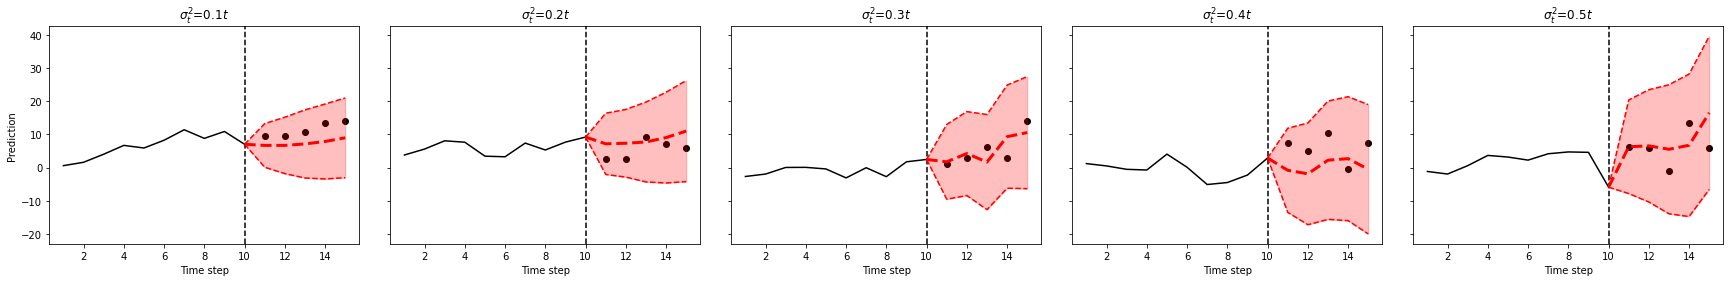

In [1137]:
plot_compare(test_datasets, all_coverages, all_intervals)


In [1049]:
all_coverages = [result['coverages'] for result in results_time_dependent_noise_no_periodic]
all_intervals = [result['intervals'] for result in results_time_dependent_noise_no_periodic]